In [1]:
import csv
import math
import pickle
import datetime as dt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import sklearn

from scipy import stats
from dateutil.parser import parse
from datetime import datetime
from IPython.display import display_html
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from pprint import pprint
from sklearn.preprocessing import OrdinalEncoder
from catboost import CatBoostRegressor
from scipy.stats import linregress

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('fivethirtyeight')
pd.options.display.float_format = '{:.2f}'.format

Description : This notebook contains Re-predictions Model Evaluation <br>
    1. Predictions on hold out sample for the CatBoost Model & Random Forest Model <br>
    2. Out of Sample Validation using CatBoost & Random Forest Model <br>

In [36]:
from IPython.display import HTML

HTML('''
<script src='//code.jquery.com/jquery-3.3.1.min.js'></script>
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 $('div .jp-CodeCell .jp-Cell-inputWrapper').hide();
 } else {
 $('div.input').show();
 $('div .jp-CodeCell .jp-Cell-inputWrapper').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Code on/off"></form>''')

In [2]:
# calculate rmse scores
def rmse(pred_test, y_test):
    return np.sqrt(((pred_test - y_test) ** 2).mean())

# calculate mape scores
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## **Load Analytical Dataset**

In [3]:
## Load ADS using name and path

load_ads = pd.read_csv('gs://aes-analytics-0002-curated/Outage_Restoration/Repredictions/Master_Dataset/OMS_IPL_V1.csv', index_col=0)
load_ads = load_ads[load_ads.TR>0]
load_ads['CREATION_DATETIME'] = pd.to_datetime(load_ads['CREATION_DATETIME'], infer_datetime_format = True, errors = 'coerce')

# Getting info for training dataset
event_id = load_ads['EVENT']
outage_id = load_ads[['OUTAGE_ID', 'INCIDENT_ID', 'STRCTUR_NO', 'EVENT', 'CREATION_DATETIME', 'ENERGIZED_DATETIME',
                        'CIRCT_ID', 'SUBST_ID', 'ETR_DATETIME', 'Marker_Location', 'RANK_SUBSEQUENT_OUTAGES', 'LAT', 'LONG', 'Live_outage_group']]

# Dropping unnecessary columns
load_ads.drop(columns= ['OUTAGE_ID', 'INCIDENT_ID', 'STRCTUR_NO', 'EVENT', 'CREATION_DATETIME', 'ENERGIZED_DATETIME',
                        'CIRCT_ID', 'SUBST_ID', 'ETR_DATETIME', 'Marker_Location', 'RANK_SUBSEQUENT_OUTAGES', 'LAT', 'LONG', 'Live_outage_group'], inplace=True)
print(load_ads.shape)
display(load_ads.head())

(561196, 147)


,DNI_EQUIP_TYPE,CALL_QTY,DOWNSTREAM_CUST_QTY,KEY_CUST_QTY,CUST_QTY,DAY_FLAG,POLE_CLUE_FLG,PART_LIGHT_CLUE_FLG,EMERGENCY_CLUE_FLG,POWER_OUT_CLUE_FLG,OPEN_DEVICE_CLUE_FLG,TREE_CLUE_FLG,WIRE_DOWN_CLUE_FLG,IVR_CLUE_FLG,EQUIPMENT_CLUE_FLG,TRANSFORMER_CLUE_FLG,OH_CAUSE_FLG,UG_CAUSE_FLG,ANIMAL_CAUSE_FLG,WEATHER_CAUSE_FLG,WEATHER_COLD_CAUSE_FLG,PUBLIC_CAUSE_FLG,WEATHER_LIGHTNING_CAUSE_FLG,WEATHER__SNOW_CAUSE_FLG,WEATHER__WIND_CAUSE_FLG,WEATHER__HEAT_CAUSE_FLG,CUST_REQUEST_CAUSE_FLG,WEATHER__FLOOD_CAUSE_FLG,STREET_CAUSE_FLG,SUBSTATION_CAUSE_FLG,TREE_CAUSE_FLG,MISCELLANEOUS_CAUSE_FLG,NO_CAUSE_FLG,PLANNED_CAUSE_FLG,NO_OUTAGE_CAUSE_FLG,FUSE_OCCURN_FLG,CUST_EQUIP_OCCURN_FLG,POLE_OCCURN_FLG,TRANSFORMER_OCCURN_FLG,METER_OCCURN_FLG,SERVICE_OCCURN_FLG,CABLE_OCCURN_FLG,ST_OCCURN_FLG,FIRE_OCCURN_FLG,FOUND_OPEN_OCCURN_FLG,PUBLIC_SAFETY_OCCURN_FLG,WIRE_OCCURN_FLG,SWITCH_OCCURN_FLG,REGULATOR_OCCURN_FLG,CUTOUT_OCCURN_FLG,CAP_BANK_OCCURN_FLG,RECLOSER_OCCURN_FLG,OH_OCCURN_FLG,PRIORITY_VAL_1.0,PRIORITY_VAL_2.0,PRIORITY_VAL_3.0,PRIORITY_VAL_5.0,CITY_NAM,ZONE,NO_OF_POWER_OUT_CLUE_PER_DAY,NO_OF_OPEN_DEVICE_CLUE_PER_DAY,NO_OF_IVR_CLUE_PER_DAY,NO_OF_ANIMAL_CAUSE_PER_DAY,NO_OF_WIRE_OCCURN_PER_DAY,Hour_Sin,Hour_Cos,LIVE_OUTAGE,Outages_in_last_1hr,Outages_in_last_2hr,Outages_in_last_3hr,Outages_in_last_4hr,Outages_in_last_5hr,Outages_in_last_6hr,Outages_in_last_7hr,Outages_in_last_8hr,Outages_in_last_9hr,Outages_in_last_10hr,Weekday,Weekend_flag,Priority_Customer_Qty,Dis_From_Live_Centriod_div_Cust_qty,Priority_Dist_Customer_Qty,Dispatch_Location,cldCvrAvg,cldCvrMax,cldCvrMin,dewPtAvg,dewPtMax,dewPtMin,feelsLikeAvg,feelsLikeMax,feelsLikeMin,heatIndexAvg,heatIndexMax,heatIndexMin,mslPresAvg,mslPresMax,mslPresMin,precip,radSolarAvg,radSolarMax,radSolarTot,relHumAvg,relHumMax,relHumMin,sfcPresAvg,sfcPresMax,sfcPresMin,snowfall,spcHumAvg,spcHumMax,spcHumMin,tempAvg,tempMax,tempMin,wetBulbAvg,wetBulbMax,wetBulbMin,windChillAvg,windChillMax,windChillMin,windDir100mAvg,windDir80mAvg,windDirAvg,windSpd100mAvg,windSpd100mMax,windSpd100mMin,windSpd80mAvg,windSpd80mMax,windSpd80mMin,windSpdAvg,windSpdMax,windSpdMin,tempRange,windSpdRange,sfcPresRange,cldCvrRange,relHumRange,relHumRatio,sfcPresRatio,Time_Since_Outage,TR,Slope_outages,Slope_ROC_outages,max_ROC_outages,max_index_ROC,weight_ROC
0,SSUB,4,177.00,1.00,177.00,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,INDIANAPOLIS,ZONE3,7,1,5,2,1,0.71,0.71,0,0,0,0,0,0,0,0,0,0,0,Monday,False,1.00,0.00,1.00,ARL.,92.00,100.00,44.00,33.90,39.50,30.00,30.30,36.70,24.30,38.50,43.70,34.50,1016.40,1026.00,1008.90,0.00,28.50,125.40,684.30,83.30,90.30,79.30,986.80,995.80,980.10,0.00,4.20,5.20,3.60,38.50,43.70,34.50,36.60,41.70,32.80,30.30,36.70,24.30,269.00,269.00,267.00,16.80,20.30,8.80,17.00,20.60,8.90,14.40,17.80,6.70,9.20,11.10,15.70,56.00,11.00,1.14,1.02,0.00,15.00,nan,nan,0,1,0.00
1,1TBOH,2,6.00,0.00,6.00,True,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,INDIANAPOLIS,ZONE4,7,1,5,2,1,0.71,-0.71,1,0,1,1,1,1,1,2,2,2,2,Monday,False,1.00,0.66,1.00,MILL,90.00,100.00,42.00,33.50,39.10,29.70,29.80,36.00,23.80,38.10,42.90,34.10,1016.70,1026.10,1009.30,0.00,29.50,130.10,707.00,83.70,90.00,79.00,987.90,996.80,981.30,0.00,4.10,5.20,3.50,38.10,42.90,34.10,36.20,41.10,32.40,29.80,36.00,23.80,269.00,269.00,267.00,16.60,20.30,8.80,16.80,20.50,8.90,14.30,17.80,6.70,8.80,11.10,15.50,58.00,11.00,1.14,1.02,0.00,39.60,4.02,-1.93,1,1,0.10
2,1TBOH,2,6.00,0.00,6.00,True,False,False,False,True,False,False,False,True,False,False,False,False,True,Fa

In [4]:
load_ads.dropna(subset=['Slope_ROC_outages', 'Slope_outages'],inplace=True)

## **Load Features and Model Objects**

In [5]:
# load features dataset for catboost & random forest
df_catboost_features = pd.read_csv('gs://aes-analytics-0002-curated/Outage_Restoration/Repredictions/Model/IPL_TTR_Catboost_11272020.csv')
df_rf_features = pd.read_csv('gs://aes-analytics-0002-curated/Outage_Restoration/Model_object/Random_Forest_GridSearch_09172020.csv', index_col=False)

In [6]:
cat_final_features = list(df_catboost_features.Features.unique())
print(len(cat_final_features))
print(cat_final_features)
print('\n')

40
['Time_Since_Outage', 'Priority_Customer_Qty', 'CALL_QTY', 'NO_OF_WIRE_OCCURN_PER_DAY', 'NO_OF_POWER_OUT_CLUE_PER_DAY', 'LIVE_OUTAGE', 'Outages_in_last_1hr', 'CUST_QTY', 'DOWNSTREAM_CUST_QTY', 'Priority_Dist_Customer_Qty', 'Dispatch_Location', 'Dis_From_Live_Centriod_div_Cust_qty', 'Outages_in_last_2hr', 'precip', 'weight_ROC', 'max_ROC_outages', 'Outages_in_last_5hr', 'Outages_in_last_4hr', 'DNI_EQUIP_TYPE', 'windSpdRange', 'Hour_Cos', 'PRIORITY_VAL_1.0', 'windSpdMax', 'tempRange', 'NO_OF_OPEN_DEVICE_CLUE_PER_DAY', 'Outages_in_last_3hr', 'windSpd100mMax', 'Slope_ROC_outages', 'Hour_Sin', 'relHumRange', 'dewPtMax', 'Outages_in_last_7hr', 'Outages_in_last_8hr', 'ZONE', 'Outages_in_last_10hr', 'TREE_CAUSE_FLG', 'Outages_in_last_6hr', 'windSpdAvg', 'Slope_outages', 'FUSE_OCCURN_FLG']




In [7]:
rf_final_feautres = list(df_rf_features.Features_List.unique())
print(list(df_rf_features.Features_List.unique()))

['windDir100mAvg', 'POWER_OUT_CLUE_FLG_True', 'Hour_Cos', 'FUSE_OCCURN_FLG_False', 'NO_OF_IVR_CLUE_PER_DAY', 'NO_OF_POWER_OUT_CLUE_PER_DAY', 'Outages_in_last_1hr', 'Priority_Customer_Qty', 'ANIMAL_CAUSE_FLG_False', 'UG_CAUSE_FLG_False', 'tempRange', 'NO_OF_WIRE_OCCURN_PER_DAY', 'radSolarTot', 'PUBLIC_SAFETY_OCCURN_FLG_True', 'Outages_in_last_10hr', 'NO_CAUSE_FLG_False', 'cldCvrRange', 'windSpd80mMax', 'Hour_Sin', 'CALL_QTY', 'NO_OF_OPEN_DEVICE_CLUE_PER_DAY', 'TREE_CAUSE_FLG_True', 'Outages_in_last_2hr', 'TREE_CAUSE_FLG_False', 'Priority_Dist_Customer_Qty', 'relHumAvg', 'POLE_CLUE_FLG_False', 'DOWNSTREAM_CUST_QTY', 'Outages_in_last_9hr', 'heatIndexMax', 'DAY_FLAG_True', 'WIRE_OCCURN_FLG_False', 'ANIMAL_CAUSE_FLG_True', 'ST_OCCURN_FLG_False', 'CITY_NAM_NO_CITY', 'PUBLIC_SAFETY_OCCURN_FLG_False', 'ST_OCCURN_FLG_True', 'POWER_OUT_CLUE_FLG_False']


In [8]:
# load hyper paramter tuned random forest model object 
rf_model = pd.read_pickle('gs://aes-analytics-0002-curated/Outage_Restoration/Model_object/Random_Forest_GridSearch_09172020.pkl')

# load hyper parameter tuned catboost model object for re-predicitons
catboost_model = pd.read_pickle('gs://aes-datahub-0002-curated/Outage_Restoration/Historical_Data/PickleFiles/IPL_TTR_Catboost_11272020.pkl')

In [9]:
X = load_ads[cat_final_features]
y = load_ads['TR']

# Split data for validation
x, x_hold, y, y_hold = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42)

# create eval set
x_train, x_val, y_train, y_val = train_test_split(
    x, y,
    test_size=0.2,
    random_state=42)

In [10]:
x_hold.reset_index(drop=True, inplace=True)
y_hold.reset_index(drop=True, inplace=True)

In [11]:
x_hold = x_hold[x_hold.Time_Since_Outage==0]

x_index_list = x_hold.index.values.tolist()
y_hold = y_hold.loc[x_index_list]
y_hold.reset_index(drop=True, inplace=True)

print(len(x_hold), len(y_hold))

15081 15081


#### **Model Evaluation for initial predictions**

In [12]:
model_col = ['MODEL_NAME' , 'TEST_MSE', 'TEST_RMSE', 'TEST_MAE', 'TEST_MAPE', 'TEST_R2']
model_result_df = pd.DataFrame(columns=model_col)
data_test_list = pd.DataFrame()
i=0

In [13]:
X = x_hold
y = y_hold

y_test_pred = catboost_model.predict(X)

mse_test = mean_squared_error(y, y_test_pred)
rmse_test = rmse(y,y_test_pred)
mae_test = mean_absolute_error(y, y_test_pred)
mape_test = mean_absolute_percentage_error(y,y_test_pred)
r2_test = r2_score(y,y_test_pred)

data_test = pd.DataFrame({'Model':'CatBoost', 'Test_Predicted': list(y_test_pred),'Test_Actual': list(y)})
data_test_list = data_test_list.append(data_test)
data_test_list.reset_index(drop=True, inplace=True)

model_result_df.loc[i] = ['CatBoost', mse_test, rmse_test, mae_test, mape_test, r2_test]
i = i + 1

In [14]:
model_result_df.head()

,MODEL_NAME,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2
0,CatBoost,8588.31,92.67,60.97,85.46,0.93


## **CatBoost Tuned: Actual vs Fitted Plot Intial Predictions**

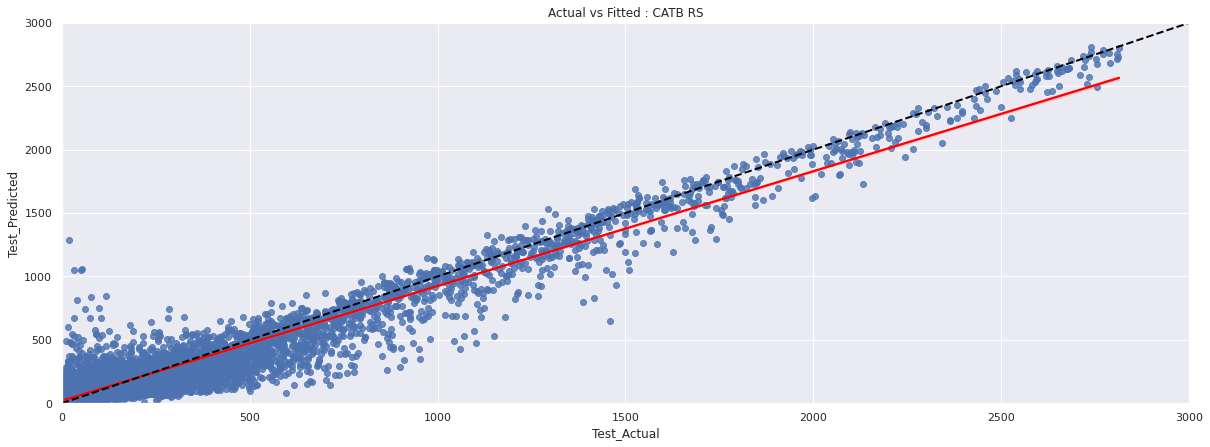

In [15]:
sns.set(rc={'figure.figsize':(18,7)})
sns.set_style("darkgrid")

ax = sns.regplot(x="Test_Actual", y="Test_Predicted", data=data_test_list[data_test_list.Model=='CatBoost'], line_kws={"color": "red"})
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
ax.set_title('Actual vs Fitted : CATB RS')
points = np.linspace(0, 3000, 100)
ax = sns.lineplot(points, points, color='black', marker=None,linestyle='--', linewidth=2.0)

In [16]:
ads_df_rf = load_ads.copy(deep=True)
ads_df_rf = pd.get_dummies(ads_df_rf, columns=['DAY_FLAG', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 
                                   'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG',
                                   'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 
                                   'WEATHER_COLD_CAUSE_FLG', 'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 
                                   'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 
                                   'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG', 'NO_CAUSE_FLG', 
                                   'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 
                                   'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG',
                                   'FIRE_OCCURN_FLG', 'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG', 'WIRE_OCCURN_FLG', 'SWITCH_OCCURN_FLG', 
                                   'REGULATOR_OCCURN_FLG', 'CUTOUT_OCCURN_FLG', 'CAP_BANK_OCCURN_FLG', 'RECLOSER_OCCURN_FLG', 'OH_OCCURN_FLG', 
                                   'PRIORITY_VAL_1.0', 'PRIORITY_VAL_2.0', 'PRIORITY_VAL_3.0', 'PRIORITY_VAL_5.0', 'CITY_NAM', 
                                   'ZONE', 'Weekday', 'Weekend_flag', 'Dispatch_Location'])

In [17]:
X = ads_df_rf
y = ads_df_rf['TR']

# Split data for validation
x, x_hold, y, y_hold = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42)

# create eval set
x_train, x_val, y_train, y_val = train_test_split(
    x, y,
    test_size=0.2,
    random_state=42)

In [18]:
x_hold.reset_index(drop=True, inplace=True)
y_hold.reset_index(drop=True, inplace=True)

In [19]:
x_hold = x_hold[x_hold.Time_Since_Outage==0]

x_index_list = x_hold.index.values.tolist()
y_hold = y_hold.loc[x_index_list]
y_hold.reset_index(drop=True, inplace=True)

print(len(x_hold), len(y_hold))

15081 15081


In [20]:
X = x_hold[rf_final_feautres]
y = np.log(y_hold)

y_test_pred = rf_model.predict(X)
y_test_pred = np.exp(y_test_pred)

y = np.exp(y)

mse_test = mean_squared_error(y, y_test_pred)
rmse_test = rmse(y,y_test_pred)
mae_test = mean_absolute_error(y, y_test_pred)
mape_test = mean_absolute_percentage_error(y,y_test_pred)
r2_test = r2_score(y,y_test_pred)

data_test = pd.DataFrame({'Model':'Random Forest HPT', 'Test_Predicted': list(y_test_pred),'Test_Actual': list(y)})
data_test_list = data_test_list.append(data_test)
data_test_list.reset_index(drop=True, inplace=True)

model_result_df.loc[i] = ['Random Forest HPT', mse_test, rmse_test, mae_test, mape_test, r2_test]
i = i + 1

In [21]:
model_result_df

,MODEL_NAME,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2
0,CatBoost,8588.31,92.67,60.97,85.46,0.93
1,Random Forest HPT,17010.04,130.42,53.31,30.64,0.86


## **Random Forest Tuned: Actual vs Fitted PLot Intial Predictions**

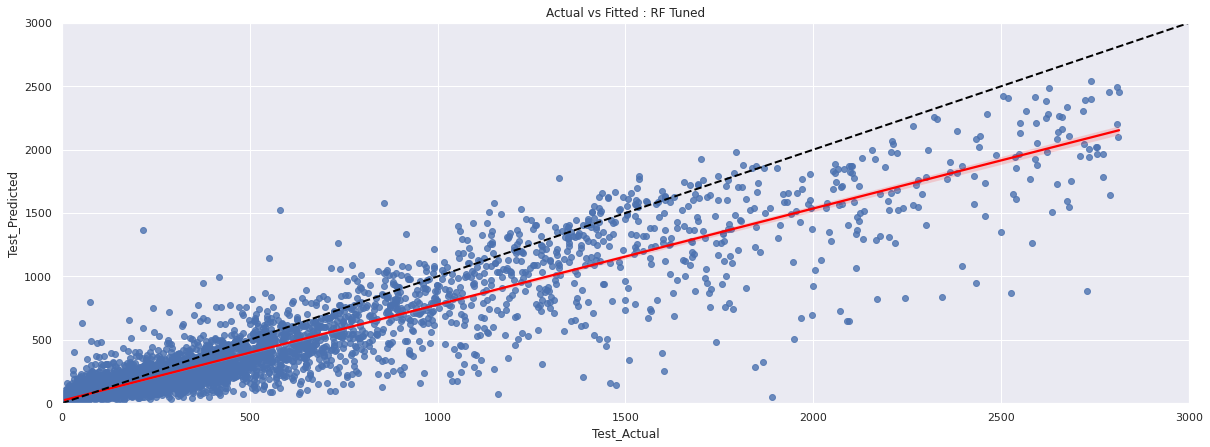

In [23]:
sns.set(rc={'figure.figsize':(18,7)})
sns.set_style("darkgrid")

ax = sns.regplot(x="Test_Actual", y="Test_Predicted", data=data_test_list[data_test_list.Model=='Random Forest HPT'], line_kws={"color": "red"})
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
ax.set_title('Actual vs Fitted : RF Tuned')
points = np.linspace(0, 3000, 100)
ax = sns.lineplot(points, points, color='black', marker=None,linestyle='--', linewidth=2.0)

## **Model Evaluation Out of Sample Validation**

In [24]:
# load 2020 out of sample validation data
df_ads_2020 = pd.read_csv('gs://aes-analytics-0002-curated/Outage_Restoration/Historical_Data/Master_Dataset/OMS_IPL_2020_11162020.csv')
df_ads_2020.head()

,OUTAGE_ID,INCIDENT_ID,STRCTUR_NO,EVENT,CREATION_DATETIME,ENERGIZED_DATETIME,CIRCT_ID,DNI_EQUIP_TYPE,SUBST_ID,CALL_QTY,DOWNSTREAM_CUST_QTY,KEY_CUST_QTY,ETR_DATETIME,CUST_QTY,DAY_FLAG,TTR,POLE_CLUE_FLG,PART_LIGHT_CLUE_FLG,EMERGENCY_CLUE_FLG,POWER_OUT_CLUE_FLG,OPEN_DEVICE_CLUE_FLG,TREE_CLUE_FLG,WIRE_DOWN_CLUE_FLG,IVR_CLUE_FLG,EQUIPMENT_CLUE_FLG,TRANSFORMER_CLUE_FLG,OH_CAUSE_FLG,UG_CAUSE_FLG,ANIMAL_CAUSE_FLG,WEATHER_CAUSE_FLG,WEATHER_COLD_CAUSE_FLG,PUBLIC_CAUSE_FLG,WEATHER_LIGHTNING_CAUSE_FLG,WEATHER__SNOW_CAUSE_FLG,WEATHER__WIND_CAUSE_FLG,WEATHER__HEAT_CAUSE_FLG,CUST_REQUEST_CAUSE_FLG,WEATHER__FLOOD_CAUSE_FLG,STREET_CAUSE_FLG,SUBSTATION_CAUSE_FLG,TREE_CAUSE_FLG,MISCELLANEOUS_CAUSE_FLG,NO_CAUSE_FLG,PLANNED_CAUSE_FLG,NO_OUTAGE_CAUSE_FLG,FUSE_OCCURN_FLG,CUST_EQUIP_OCCURN_FLG,POLE_OCCURN_FLG,TRANSFORMER_OCCURN_FLG,METER_OCCURN_FLG,SERVICE_OCCURN_FLG,CABLE_OCCURN_FLG,ST_OCCURN_FLG,FIRE_OCCURN_FLG,FOUND_OPEN_OCCURN_FLG,PUBLIC_SAFETY_OCCURN_FLG,WIRE_OCCURN_FLG,SWITCH_OCCURN_FLG,REGULATOR_OCCURN_FLG,CUTOUT_OCCURN_FLG,CAP_BANK_OCCURN_FLG,RECLOSER_OCCURN_FLG,OH_OCCURN_FLG,PRIORITY_VAL_1.0,PRIORITY_VAL_2.0,PRIORITY_VAL_3.0,PRIORITY_VAL_5.0,CITY_NAM,LAT,LONG,ZONE,COMMENT_TEXT,NO_OF_POWER_OUT_CLUE_PER_DAY,NO_OF_OPEN_DEVICE_CLUE_PER_DAY,NO_OF_IVR_CLUE_PER_DAY,NO_OF_ANIMAL_CAUSE_PER_DAY,NO_OF_WIRE_OCCURN_PER_DAY,Marker_Location,Hour_Sin,Hour_Cos,RANK_SUBSEQUENT_OUTAGES,LIVE_OUTAGE,Outages_in_last_1hr,Outages_in_last_2hr,Outages_in_last_3hr,Outages_in_last_4hr,Outages_in_last_5hr,Outages_in_last_6hr,Outages_in_last_7hr,Outages_in_last_8hr,Outages_in_last_9hr,Outages_in_last_10hr,Weekday,Weekend_flag,Live_outage_group,Priority_Customer_Qty,Dis_From_Live_Centriod_div_Cust_qty,Priority_Dist_Customer_Qty,Dispatch_Location,cldCvrMin,cldCvrAvg,cldCvrMax,dewPtMin,dewPtAvg,dewPtMax,feelsLikeMin,feelsLikeAvg,feelsLikeMax,heatIndexMin,heatIndexAvg,heatIndexMax,mslPresMin,mslPresAvg,mslPresMax,precip,radSolarAvg,radSolarMax,radSolarTot,relHumMin,relHumAvg,relHumMax,sfcPresMin,sfcPresAvg,sfcPresMax,snowfall,spcHumMin,spcHumAvg,spcHumMax,tempMin,tempAvg,tempMax,windChillMin,windChillAvg,windChillMax,windDirAvg,windDir80mAvg,windDir100mAvg,windSpdMin,windSpdAvg,windSpdMax,windSpd80mMin,windSpd80mAvg,windSpd80mMax,windSpd100mMin,windSpd100mAvg,windSpd100mMax,wetBulbMin,wetBulbAvg,wetBulbMax,tempRange,windSpdRange,sfcPresRange,cldCvrRange,relHumRange,relHumRatio,sfcPresRatio,Active_no_of_trucks_per_day
0,2002645939,2001465208.00,462-B/97,BLUE SKY,2020-01-01 00:03:00,2020-01-01 02:30:00,3209.00,FUSE,320.00,26,30.00,1.00,2020-01-01 03:45:00,30.00,False,147.00,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,INDIANAPOLIS,39.79,-86.19,ZONE4,NaN,37,2,17,8,5,Marker11,0.00,1.00,1.00,0,0,0,0,0,0,0,0,0,0,0,Wednesday,False,1,1.00,0.18,1.00,MILL,0.00,27.00,100.00,25.50,27.90,29.80,26.20,33.40,42.80,31.80,38.60,46.70,1007.00,1010.70,1013.50,0.00,118.60,499.20,2846.90,43.20,67.00,89.00,981.60,984.80,987.40,0.00,3.00,3.30,3.50,31.80,38.60,46.70,26.20,33.40,42.80,220.00,216.00,218.00,5.00,7.20,10.40,12.50,18.00,28.60,13.00,17.90,27.70,30.50,34.70,39.30,14.90,5.40,5.80,100.00,45.80,2.06,1.01,nan
1,2002646057,2001465296.00,281-B/193,BLUE SKY,2020-01-01 03:10:16,2020-01-01 11:46:19,3607.00,FUSE,360.00,3,2.00,0.00,2020-01-01 07:45:00,2.00,False,516.05,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,INDIANAPOLIS,39.88,-86.02,ZONE3,LOCATION CREATED BY OPENING DEVICE: 281-B/193 ...,37,2,17,8,5,Marker5,0.71,0.71,3.00,0,0,0,1,2,2,2,2,2,2,2,Wednesday,False,2,1.00,0.00,1.00,ARL.,0.00,28.00

In [25]:
def feature_add(group):
    group = group.reset_index(drop = True)
    x = [group.Outages_in_last_1hr[0],group.Outages_in_last_2hr[0],group.Outages_in_last_3hr[0],group.Outages_in_last_4hr[0],group.Outages_in_last_5hr[0]
        ,group.Outages_in_last_6hr[0],group.Outages_in_last_7hr[0],group.Outages_in_last_8hr[0],group.Outages_in_last_9hr[0],group.Outages_in_last_10hr[0]]
    y = [1,2,3,4,5,6,7,8,9,10]
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    group['Slope_outages'] = slope
    
    ROC = [abs(group.Outages_in_last_1hr[0] - group.Outages_in_last_2hr[0]),abs(group.Outages_in_last_2hr[0] - group.Outages_in_last_3hr[0]),
           abs(group.Outages_in_last_3hr[0] - group.Outages_in_last_4hr[0]),abs(group.Outages_in_last_4hr[0] - group.Outages_in_last_5hr[0]),
           abs(group.Outages_in_last_5hr[0] - group.Outages_in_last_6hr[0]),abs(group.Outages_in_last_6hr[0] - group.Outages_in_last_7hr[0]),
           abs(group.Outages_in_last_7hr[0] - group.Outages_in_last_8hr[0]),abs(group.Outages_in_last_8hr[0] - group.Outages_in_last_9hr[0]),
           abs(group.Outages_in_last_9hr[0] - group.Outages_in_last_10hr[0])]
    y = [1,2,3,4,5,6,7,8,9]
    slope, intercept, r_value, p_value, std_err = linregress(ROC, y)
    group['Slope_ROC_outages'] = slope
    
    group['max_ROC_outages'] = max(ROC)
    group['max_index_ROC'] = 1+ROC.index(max(ROC))    
    group['weight_ROC'] = group['max_ROC_outages'] * group['max_index_ROC']*0.1
    return group

In [26]:
df_ads_2020 = df_ads_2020.groupby(['OUTAGE_ID'], as_index = False).apply(feature_add).reset_index(drop = True)
df_ads_2020 = df_ads_2020[df_ads_2020.TTR>30]
df_ads_2020 = df_ads_2020[df_ads_2020.TTR<5000]

In [27]:
df_ads_2020.reset_index(drop=True, inplace=True)
df_ads_2020['Time_Since_Outage'] = 0

In [28]:
X = df_ads_2020[cat_final_features]
y = df_ads_2020.TTR

y_test_pred = catboost_model.predict(X)

mse_test = mean_squared_error(y, y_test_pred)
rmse_test = rmse(y,y_test_pred)
mae_test = mean_absolute_error(y, y_test_pred)
mape_test = mean_absolute_percentage_error(y,y_test_pred)
r2_test = r2_score(y,y_test_pred)

data_test = pd.DataFrame({'Model':'CatBoost_2020', 'Test_Predicted': list(y_test_pred),'Test_Actual': list(y)})
data_test_list = data_test_list.append(data_test)
data_test_list.reset_index(drop=True, inplace=True)

model_result_df.loc[i] = ['CatBoost_2020', mse_test, rmse_test, mae_test, mape_test, r2_test]
i = i + 1

In [29]:
model_result_df

,MODEL_NAME,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2
0,CatBoost,8588.31,92.67,60.97,85.46,0.93
1,Random Forest HPT,17010.04,130.42,53.31,30.64,0.86
2,CatBoost_2020,127367.33,356.89,205.73,181.79,0.09


## **CatBoost Tuned: Actual vs Fitted PLot 2020 Out of Sample Predictions**

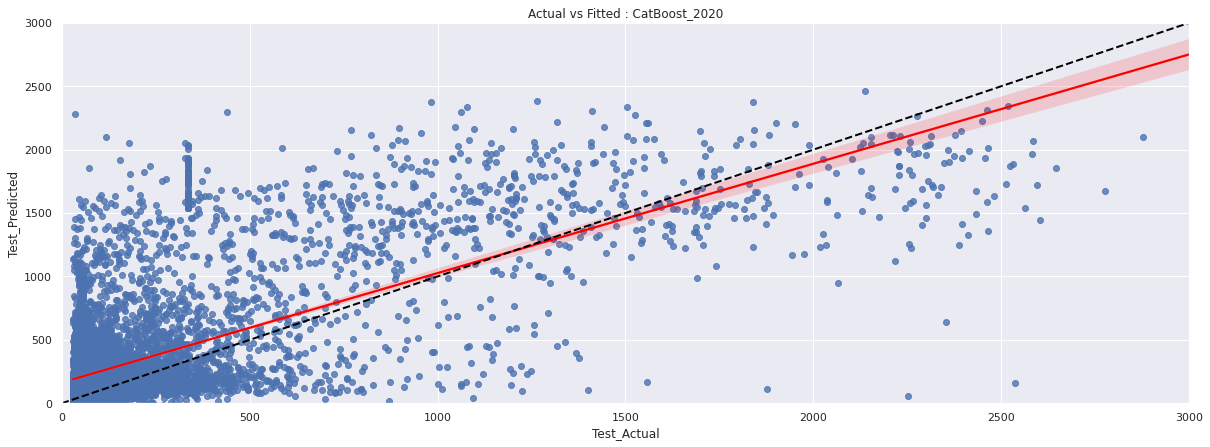

In [30]:
sns.set(rc={'figure.figsize':(18,7)})
sns.set_style("darkgrid")

ax = sns.regplot(x="Test_Actual", y="Test_Predicted", data=data_test_list[data_test_list.Model=='CatBoost_2020'], line_kws={"color": "red"})
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
ax.set_title('Actual vs Fitted : CatBoost_2020')
points = np.linspace(0, 3000, 100)
ax = sns.lineplot(points, points, color='black', marker=None,linestyle='--', linewidth=2.0)

In [32]:
storm_df = df_ads_2020.copy(deep=True)
storm_df = pd.get_dummies(storm_df, columns=['DAY_FLAG', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 
                                   'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG',
                                   'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 
                                   'WEATHER_COLD_CAUSE_FLG', 'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 
                                   'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 
                                   'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG', 'NO_CAUSE_FLG', 
                                   'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 
                                   'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG',
                                   'FIRE_OCCURN_FLG', 'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG', 'WIRE_OCCURN_FLG', 'SWITCH_OCCURN_FLG', 
                                   'REGULATOR_OCCURN_FLG', 'CUTOUT_OCCURN_FLG', 'CAP_BANK_OCCURN_FLG', 'RECLOSER_OCCURN_FLG', 'OH_OCCURN_FLG', 
                                   'PRIORITY_VAL_1.0', 'PRIORITY_VAL_2.0', 'PRIORITY_VAL_3.0', 'PRIORITY_VAL_5.0', 'CITY_NAM', 
                                   'ZONE', 'Weekday', 'Weekend_flag', 'Dispatch_Location'])

In [33]:
X = storm_df[rf_final_feautres]
y = np.log(storm_df.TTR)

y_test_pred = rf_model.predict(X)
y_test_pred = np.exp(y_test_pred)

y = np.exp(y)

mse_test = mean_squared_error(y, y_test_pred)
rmse_test = rmse(y,y_test_pred)
mae_test = mean_absolute_error(y, y_test_pred)
mape_test = mean_absolute_percentage_error(y,y_test_pred)
r2_test = r2_score(y,y_test_pred)

data_test = pd.DataFrame({'Model':'Random Forest 2020', 'Test_Predicted': list(y_test_pred),'Test_Actual': list(y)})
data_test_list = data_test_list.append(data_test)
data_test_list.reset_index(drop=True, inplace=True)

model_result_df.loc[i] = ['Random Forest 2020', mse_test, rmse_test, mae_test, mape_test, r2_test]
i = i + 1

In [34]:
model_result_df

,MODEL_NAME,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2
0,CatBoost,8588.31,92.67,60.97,85.46,0.93
1,Random Forest HPT,17010.04,130.42,53.31,30.64,0.86
2,CatBoost_2020,127367.33,356.89,205.73,181.79,0.09
3,Random Forest 2020,80051.74,282.93,161.01,134.61,0.43


## **Random Forest Tuned: Actual vs Fitted PLot 2020 Out of Sample Predictions**

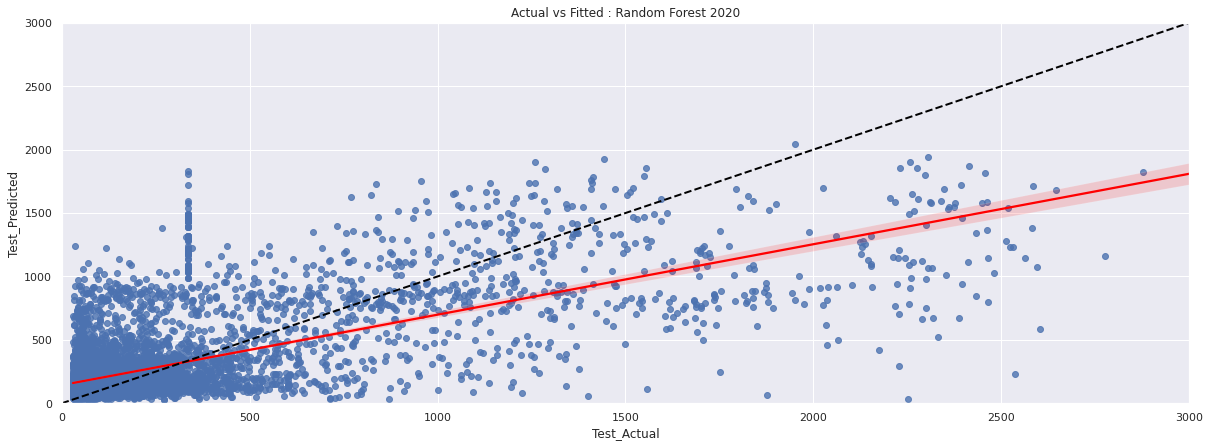

In [35]:
sns.set(rc={'figure.figsize':(18,7)})
sns.set_style("darkgrid")

ax = sns.regplot(x="Test_Actual", y="Test_Predicted", data=data_test_list[data_test_list.Model=='Random Forest 2020'], line_kws={"color": "red"})
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
ax.set_title('Actual vs Fitted : Random Forest 2020')
points = np.linspace(0, 3000, 100)
ax = sns.lineplot(points, points, color='black', marker=None,linestyle='--', linewidth=2.0)